# **Подходы к интерпретации и визуальному представлению полученных интерпретаций для алгоритма линейной регрессии.**

### **Ограничения применения:**

1. Признаки $x_i$ должны линейно влиять на целевую переменную. Это обосновано тем, что линейная регрессия применяется на основе предположения о том что целевая переменная линейно зависит от признаков с постоянным шумом $ϵ$ $y = (w, x) + ϵ$([вероятностная постановка задачи](https://habr.com/ru/articles/514818/#secProbability)).  Кроме того, сам шум $ϵ$ должен быть распределен [нормальным образом](https://ru.wikipedia.org/wiki/Нормальное_распределение). \
\
В случае нелинейности влияния признаков на целевую переменную, можно попробовать исправить ситуацию преобразованием данных.

  **Для непрерывных признаков:** логарифмирование, извлечения корня, взятие синуса, `z-score` преобразование, `StandardScaler`, `MinMaxScaler` и [другие преобразования](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).
  
  **Для категориальных признаков:** One-Hot encoding. Для избежания линейной зависимости удаляется столбец одной из категорий, однако это делается не всегда — только если в датасете прдеставлены ВСЕ возможные категории, которые будет обрабатывать модель (иными словами, нет строчек, где все категории тренировочного набора данных равны 0).  \

  Также можно скомбинировать подходы. Например, разбить непрерывный признак на квантили [`pd.cut, pd.qcut`](https://pbpython.com/pandas-qcut-cut.html)

 **Проверить выполнение предположения о нормальном распределении шума** можно, рассмотрев остатки линейной регрессии. Именно из нормального распределения шума следует MSE как функция потерь.

2. Независимые переменные (признаки) должны быть линейно независимы друг относительно друга.


### **Признаки переобучения**

1. Большая разница прогнозов на тренировочных/валидационных и тестовых данных
2. Большие веса какого-либо признака/признаков относительно других весов

В таких случаях применяется [регуляризация](https://neerc.ifmo.ru/wiki/index.php?title=%D0%A0%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F) модели.

Регуляризация — это штраф за сложность (большие веса) модели. С её помощью можно не только избегать переобучения, но и проводить отбор признаков (L1), а также справляться с мультиколлинеарностью (L2).

### **Интерпретируемость**

Линейная регрессия относиться к [интерпретируемым](https://habr.com/ru/articles/744866/) алгоритмам. Важность признаков лежит внутри весов модели, но чтобы этот факт был полностью корректным важно помнить, что:

- данные должны быть приведены к единому машстабу.
- должна быть выполнена кодировка категориальных признаков (например, через OHE).

**В этом ноутбуке** приведены 5 методов для представления информации, которая заложена в весах модели:

1. Прямое рассмотрение коэффициентов в виде барплота.
2. Представление коэффициентов виде круговой диаграммы.
3. Рассмотрение относительного вклада коэффициентов.
4. Анализ остатков модели.
5. Построение регионов уверенности.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

from sklearn.linear_model import LinearRegression, Ridge, ElasticNetCV, Lasso
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error

Фиксируем случайность.

In [3]:
RANDOM_STATE = 42

В качестве подопытного набора данных используем [датасет о домах в Калифорнии](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset), с целевой переменной y, отрадающей медианную стоимость дома в сотнях тысяч долларов (США).

In [4]:
data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Разделим данные на тренировочную и тестовую выборки, не забыв про машстабирование.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.25)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучим линейную регрессию, и сравним предсказание с базовым.

In [6]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

predictions = lr.predict(X_test_scaled)
base = np.array([y_train.mean()]*len(X_test))

print('Качество базового алгоритма (MAE): ', mean_absolute_error(y_test, base))
print('Качество линейной регрессии (MAE): ', mean_absolute_error(y_test, predictions))

Качество базового алгоритма (MAE):  0.9100474990475331
Качество линейной регрессии (MAE):  0.5296964012919462


In [7]:
from sklearn.metrics import r2_score

print('Качество базового алгоритма (R2): ', r2_score(y_test, base))
print('Качество линейной регрессии (R2): ', r2_score(y_test, predictions))

Качество базового алгоритма (R2):  -3.8775657694056775e-05
Качество линейной регрессии (R2):  0.5910509795491351


Не отлично, но и не ужасно! Теперь — к методам.

## Метод 1. Визуализация коэффициентов в виде столбчатой диаграммы.

Коэффициенты линейной регрессии — это "веса", которые представляют собой для каждого признака (признаки еще называют независимыми переменными) силу и тип взаимосвязи независимой переменной по отношению к зависимой.

Признаки хранятся в атрибуте lr.coef_

In [8]:
labels = X_train.columns #названия признаков
values = lr.coef_ # значения весов признаков

Для начала посмотрим на табличные значения.

In [9]:
weights_data = pd.DataFrame(values, index=labels, columns=['weitght'])

weights_data

,weitght
MedInc,0.852108
HouseAge,0.120655
AveRooms,-0.302106
AveBedrms,0.348606
Population,-0.001645
AveOccup,-0.041164
Latitude,-0.893147
Longitude,-0.867840


Веса могут быть как положительными, так и отрицательными. Знак отражает тенденцию взаимосвязи.

Первый метод представить их более визуально приятно — столбчатая диаграмма барплот. Первый вариант — сохраняя тенденции взаимосвязи:

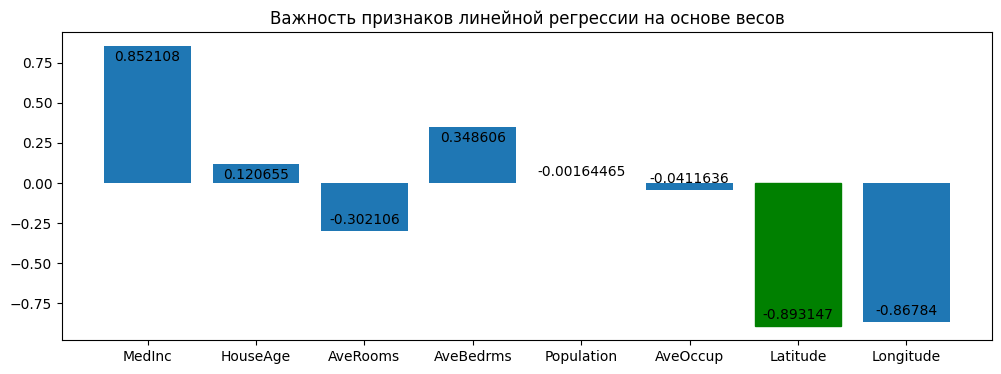

In [17]:
plt.figure(figsize=(12, 4))

bar = plt.bar(height=lr.coef_, x=labels)

bar.get_children()[np.argmax(np.abs(lr.coef_))].set_color('g') #изменим цвет наибольшего по модулю веса

plt.bar_label(bar, padding=-13, color='black') #изменим цвет наибольшего веса

plt.title('Важность признаков линейной регрессии на основе весов');

Второй — визуализируя абсолютные значения:

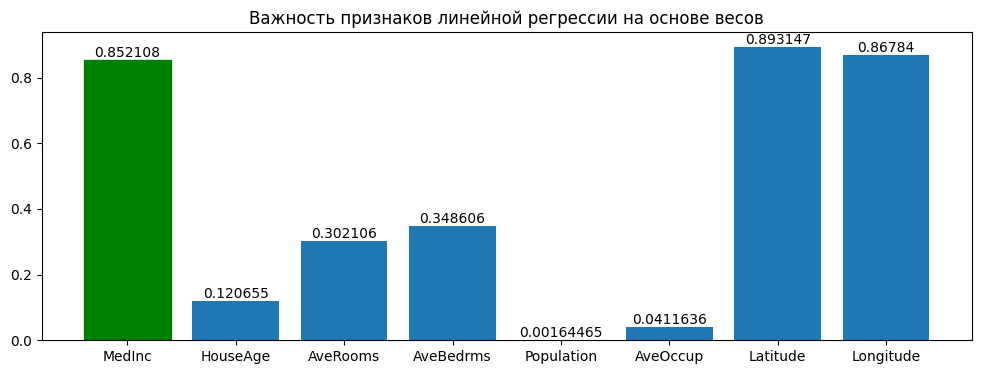

In [18]:
plt.figure(figsize=(12, 4))

bar = plt.bar(height=np.abs(values), x=labels)


bar.get_children()[np.argmax(values)].set_color('g') #изменим цвет наибольшего веса
plt.bar_label(bar, color='black') #изменим цвет наибольшего веса

plt.title('Важность признаков линейной регрессии на основе весов');

# Метод 2. Визуализация коэффициентов при помощи круговой диаграммы

Круговая диаграмма (pie plot) — не менее наглядный способ визуального представления важностей. Плюс такого графика — отличное долевое представление весов. Минус — невозможно сохранить информацию о положительности/отрицательности связи.

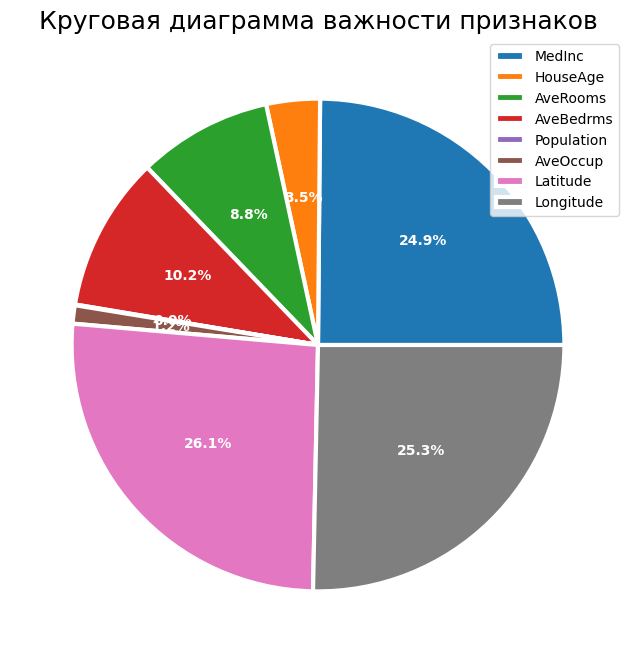

In [19]:
plt.figure(figsize=(8, 8))
patches, texts, pcts = plt.pie(np.abs(lr.coef_), autopct='%1.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},);

plt.setp(pcts, color='white', fontweight='bold')

plt.legend(X_train.columns);

plt.title('Круговая диаграмма важности признаков', fontsize=18);

# Метод 3. Вычисление относительной важности признаков

Относительная важность. Её мы уже видели выше на знаниях круговой диаграммы. Вклад признака расчитывается за счет нормирования каждого коэффициента модели на сумму абсолютных значений всех весов.

Её также можно потом визуализировать, барплотом или как раз круговой диаграммой выше. Но в виде таблицы, заранее отсортированной, представление также является  наглядным.

In [20]:
#Сделаем чуть более удобный датафрейм

weights_data2 = pd.DataFrame([labels, values]).T
weights_data2.columns = ['feature', 'feature_weitght']

weights_sum2 = sum(weights_data2['feature_weitght'])

weights_data2['feature_weitght_normalized'] = weights_data2['feature_weitght'].apply(lambda x: round(x/weights_sum2*100, 2))

In [17]:
weights_data2.sort_values(by='feature_weitght_normalized', ascending=False)

,feature,feature_weitght,feature_weitght_normalized
6,Latitude,0.893147,26.06
7,Longitude,0.86784,25.32
0,MedInc,0.852108,24.86
3,AveBedrms,0.348606,10.17
2,AveRooms,0.302106,8.81
1,HouseAge,0.120655,3.52
5,AveOccup,0.041164,1.20
4,Population,0.001645,0.05


# Метод 4. Анализ распределений остатков

Анализ остатков регрессионной модели изначально применяется для оценки её качества. Подробнее про регрессионный анализ [тут](http://www.machinelearning.ru/wiki/index.php?title=%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D0%BE%D1%81%D1%82%D0%B0%D1%82%D0%BA%D0%BE%D0%B2).

А мы сосредоточимся на интерпретации. Первый способ — рассмотреть ожидаемые и прогнозируемые значения в виде диаграммы рассеивания.

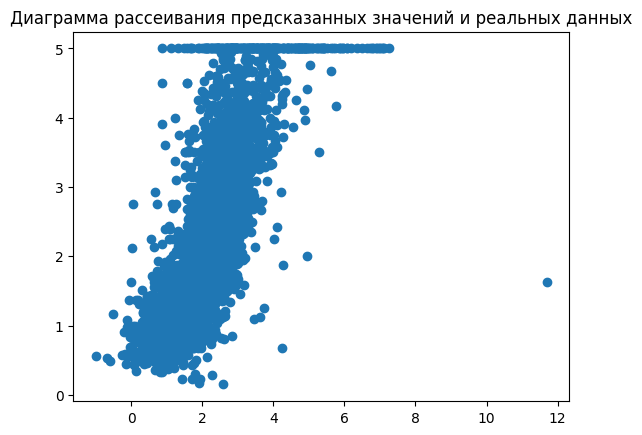

In [14]:
plt.scatter(predictions, y_test)
plt.title('Диаграмма рассеивания предсказанных значений и реальных данных');

Здесь, например, видно, что на больших значениях модель ведет себя странным образом. Соответственно наша регрессия не так хорошо справляется с прогнозированием значений для квартир с большой ценой.

Второй, не менее красивый способ увидеть это — наложить распределения прогнозируемых и ожиданиемых друг на друга. Например, так:

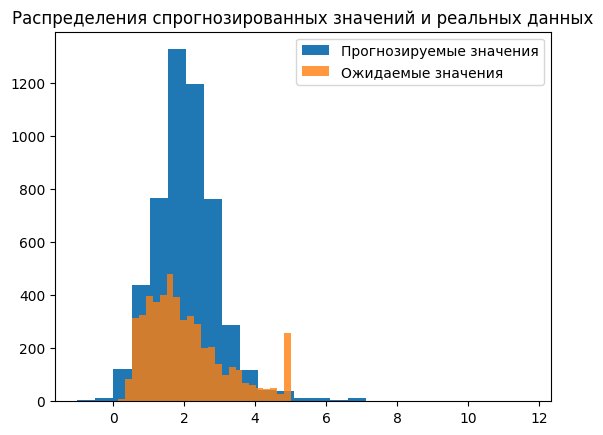

In [16]:
residuals = pd.Series(abs(predictions - y_test))

plt.hist(predictions, label='Прогнозируемые значения', bins=25);
plt.hist(y_test, label='Ожидаемые значения', bins=25, alpha=0.8);

plt.title('Распределения спрогнозированных значений и реальных данных')
plt.legend();

Так участки проблемных значений видны ещё лучше.

# Метод 5. Анализ регионов уверенности на основе остатков.

Идея этого метода — рассмотреть и продемонстрировать, в каких областях признаков модель более уверена в своих предсказаниях, а в каких — менее.

Более просто понять этот метод на задаче классификации.
Пусть есть модель, которая прогнозирует для онлайн-пользователя наличие (1) или отстсвие (0) выручки. Пусть для задачи нам наиболее важно прогнозирование отсутствия выручки. Тогда мы можем выделить наблюдения класса 0 и на основе вероятностей, выдаваемых моделью, разделить данные на интервалы:

 - низкая уверенность (вероятность "0" < 0.3).
 - средняя уверенность (0.3 <= вероятность "0" < 0.7).
 - высокая уверенность (вероятность "0" >= 0.7).

Далее рассмотрим графики, где по осям X и Y распределены некоторые признаки (пусть это будет время на сайте и число посещенных страниц). Для каждой точки будем раскрашивать область в зависимости от вероятности предсказания класса "0" — полученные визуализации помогут обнаружить, обладает ли модель регионами уверенности и, если да, то где.  

Для задачи регрессии всё тоже применимо. Мы можем разбить прогнозируемые наблюдения по квантилям абсолютных значений остатков. Например:

- класс 0 — остатки ниже 25 квантиля
- класс 1 - остатки больше 25, но ниже 75 квантиля
- класс 2 - остатки от 75 квантиля

Далее наши визулазиации будут касаться распределений признаков по одной оси и целевой переменной по другой. Пример ниже:

In [20]:
residuals = pd.Series(abs(predictions - y_test))

q1 = residuals.quantile(0.25) #группа 1, <14
q2 = residuals.quantile(0.75) #группа 2 >14 & =<62
q3 = residuals.quantile(1) #группа 3 >62

def get_resid_class(x, q1=14, q2=62, q3=154):

  if x <= q1:
    return 'low'
  elif x <= q2 and x > q1:
    return 'middle'
  elif x > q2:
    return 'high'


residuals['resid_class'] = residuals.apply(lambda x: get_resid_class(x, q1, q2, q3))

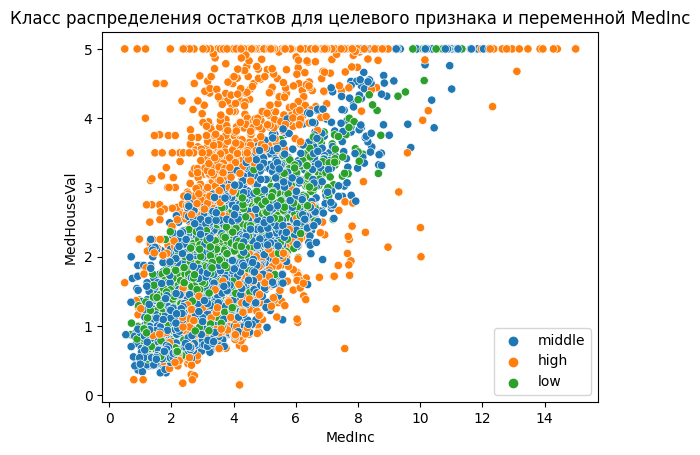

In [27]:
sns.scatterplot(x=X_test['MedInc'], y=y_test, hue=residuals['resid_class']);

plt.legend();
plt.title('Класс распределения остатков для целевого признака и переменной MedInc');

По графику видно, что наблюдения, вырывающиеся из линейного облака  связи двух переменных имеют максимальные по модулю значения остатков. Следовательно либо в данных есть выбросы и шум, либо предположение о линейности связи для признака не выполнено — этот момент по определению будет затруднять высококачественную аппроксимацию целевой переменной линейной регрессией.

На этом всё, друзья! Мы рассмотрели 5 методов для анализа и представления весов и прогнозов регрессии. Желаю вам продуктивной работы и учебы с данными!  

Встретимся в новых постах,  \
Ваш Дата-автор!